In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from keras.datasets import cifar10
import numpy.random as rng

Using TensorFlow backend.


In [2]:
import keras
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Conv2D,Input,Reshape,Layer,Flatten,Lambda,Layer,Dense
from keras import backend as k
from keras import initializers
import tensorflow as tf
from keras.utils import to_categorical


In [3]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

In [4]:
x_train.shape


(50000, 32, 32, 3)

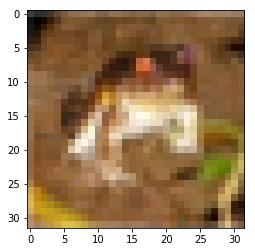

In [5]:
plt.imshow(x_train[0])

In [6]:
image_list = np.split(x_train[:50000],50000)
label_list = np.split(y_train[:50000],50000)

In [7]:
print(image_list[0].shape)
print(label_list[0].shape)

(1, 32, 32, 3)
(1, 1)


In [8]:
for i in range(len(label_list)):
    label_list[i] = label_list[i][0][0]

In [9]:
len(label_list)

50000

In [10]:
# # want to make an array (N,2,h,w,3)
# len(label_list)
_,x,y,z=image_list[2800].shape

In [11]:
for i in range(len(label_list)):
    image_list[i] = image_list[i].reshape((x,y,z))

In [12]:
image_list[0].shape

(32, 32, 3)

In [13]:
X1 = []
X2 = []
label = []
c1=0
c2=0

for i in range(len(label_list)):
    if c1<30:
        idx_1 = rng.randint(0,len(label_list))         
        idx_2 = rng.randint(0,len(label_list))       
        if label_list[idx_1] ==1 and  label_list[idx_2]==1:
            X1.append(image_list[idx_1])
            X2.append(image_list[idx_2])
            label.append(1)
            c1+=1  
            
    if c2<30:
        idx_1 = rng.randint(0,len(label_list))
        idx_2 = rng.randint(0,len(label_list))        
        if label_list[idx_1] != label_list[idx_2]:
            X1.append(image_list[idx_1])
            X2.append(image_list[idx_2])
            label.append(0)
            c2+=1
    

In [14]:
print(X1[0].shape)
print(label[2])
print(len(X1))

(32, 32, 3)
0
60


In [15]:
cnt=0
for i in range(60):
    if label[i]==1:
        cnt+=1
print(cnt)

30


In [16]:
X1= np.array(X1) #convert list to array
X2= np.array(X2)

In [17]:
print(X1.shape)
print(X2.shape)

(60, 32, 32, 3)
(60, 32, 32, 3)


In [18]:
#X1=np.squeeze(X1)

In [19]:
label = np.array(label)

In [20]:
print(label.shape)

(60,)


In [21]:
#data preparation done------------------------------------------------------------------

# Model

In [22]:
def squash(inputs):
    square_norm = k.sum(k.square(inputs),axis=-1,keepdims=True)
    return ((square_norm/(1+square_norm))/(k.sqrt(square_norm+k.epsilon())))*inputs


In [23]:
class DigitCapsuleLayer(Layer):   #0,1158,8
    def __init__(self,**kwargs):
        super(DigitCapsuleLayer,self).__init__(**kwargs)
        self.kernel_initializer=initializers.get('glorot_uniform')
    
    #initialize weight matrix for each capsule in lower laye
    def build(self,input_shape):
        self.W=self.add_weight(shape=[10,6*6*32,16,8],initializer=self.kernel_initializer,name='weights')
        self.built=True
    
    #matrix multiplication b/w previous layer output and weight matrix 
    def call(self,inputs):
        inputs=k.expand_dims(inputs,1)
        inputs=k.tile(inputs,[1,10,1,1])
        inputs=k.map_fn(lambda x:k.batch_dot(x,self.W,[2,3]),elems=inputs)
        b=tf.zeros(shape=[k.shape(inputs)[0],10,6*6*32])
    
# routing algorithm with updating coupling coefficient c, 
#using scalar product b/w input capsule and output capsule
        for i in range(3-1):
            c=tf.nn.softmax(b,dim=1)
            s=k.batch_dot(c,inputs,[2,2])
            v=squash(s)
            b=b+k.batch_dot(v,inputs,[2,3])
        return v
    def compute_output_shape(self,input_shape):
        return tuple([None,10,16])
def output_layer(inputs):
    return k.sqrt(k.sum(k.square(inputs),-1)+k.epsilon())

In [296]:
from keras import regularizers
SHAPE_Y,SHAPE_X=32,32
inputA = Input(shape=(SHAPE_Y,SHAPE_X,3))
inputB = Input(shape=(SHAPE_Y,SHAPE_X,3))

def comp_model_conv(shape=(SHAPE_Y,SHAPE_X,3)):

    actFunc='relu'    
    ip = Input(shape=(SHAPE_Y,SHAPE_X,3))
    # the first branch operates on the first input 28*28--->32*32
    x=Conv2D(256,(13,13),name='conv11',activation=actFunc, padding='valid',strides=1)(ip)
    
    #PRIMARY CAPSULE---------->>20*20
    x=Conv2D(256,(9,9),name='conv12',activation=actFunc, padding='valid',strides=2)(x)#32
    reshaped=Reshape((6*6*32,8))(x)
    squashed_output = Lambda(squash)(reshaped)
    
    #SECONDARY CAPSULE-------->>
    digit_caps=DigitCapsuleLayer()(squashed_output)
    outputs=Lambda(output_layer)(digit_caps)
    #rint(outputs.shape)
    x=Dense(32, kernel_regularizer=regularizers.l2(0.01))(outputs)
    #print(x.shape)
   # y= Flatten()(x)
    model=Model(inputs=[ip],outputs=[x])
    model.summary()
    return model



In [297]:
cmodel=comp_model_conv()
out1=cmodel(inputA)
out2=cmodel(inputB)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv11 (Conv2D)              (None, 20, 20, 256)       130048    
_________________________________________________________________
conv12 (Conv2D)              (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_3 (Reshape)          (None, 1152, 8)           0         
_________________________________________________________________
lambda_15 (Lambda)           (None, 1152, 8)           0         
_________________________________________________________________
digit_capsule_layer_3 (Digit (None, 10, 16)            1474560   
_________________________________________________________________
lambda_16 (Lambda)           (None, 10)                0         
__________

In [298]:
L1_layer = Lambda(lambda tensors:k.abs(tensors[0] - tensors[1]))
combined = L1_layer([out1, out2])

combined = Dense(1, activation = 'sigmoid')(combined)
print(combined.shape)


(?, 1)


In [299]:
X2.shape

(60, 32, 32, 3)

In [300]:
model = Model(inputs=[inputA, inputB],outputs=[combined])

model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])

In [301]:
model.fit([X1,X2], label, batch_size=20, epochs=50, verbose=1)

Epoch 1/50
60/60 [==============================] - 9s 148ms/step - loss: 0.4013 - acc: 0.4667
Epoch 2/50
60/60 [==============================] - 5s 88ms/step - loss: 0.4007 - acc: 0.5167
Epoch 3/50
60/60 [==============================] - 5s 86ms/step - loss: 0.3995 - acc: 0.5500
Epoch 4/50
60/60 [==============================] - 5s 87ms/step - loss: 0.3961 - acc: 0.6500
Epoch 5/50
60/60 [==============================] - 5s 86ms/step - loss: 0.3916 - acc: 0.6167
Epoch 6/50
60/60 [==============================] - 5s 87ms/step - loss: 0.3861 - acc: 0.7167
Epoch 7/50
60/60 [==============================] - 5s 87ms/step - loss: 0.3773 - acc: 0.7000
Epoch 8/50
60/60 [==============================] - 5s 87ms/step - loss: 0.3677 - acc: 0.7833
Epoch 9/50
60/60 [==============================] - 5s 88ms/step - loss: 0.3563 - acc: 0.8167
Epoch 10/50
60/60 [==============================] - 5s 87ms/step - loss: 0.3425 - acc: 0.8167
Epoch 11/50
60/60 [==============================] - 5s 88

In [302]:
# t = model.predict([X1,X2])

In [303]:
# t = np.round(t)

# TEST

In [502]:
x_test1 = []
x_test2 = []
c1=0
a = np.zeros((10,),dtype='int64')
testing_image_index = rng.randint(0,len(label_list))         

print("Labels:", end=" ")
for i in range(len(label_list)):
    if c1<10:
        idx_2 = rng.randint(0,len(label_list))
        if a[label_list[idx_2]]==0:
            x_test1.append(image_list[testing_image_index])
            x_test2.append(image_list[idx_2])
            a[label_list[idx_2]]+=1
            
            
            c1+=1
            print(label_list[idx_2],end="  ")
    
print("\nTesting image label:", label_list[testing_image_index])

Labels: 2  6  8  5  4  0  1  9  7  3  
Testing image label: 3


In [503]:
x_test1 = np.array(x_test1)
x_test2 = np.array(x_test2)

In [504]:
t = model.predict([x_test1,x_test2])
t

array([[0.44402438],
       [0.29545373],
       [0.6117951 ],
       [0.5329249 ],
       [0.29150528],
       [0.5005101 ],
       [0.38018718],
       [0.63863766],
       [0.42253485],
       [0.4652504 ]], dtype=float32)

In [501]:
t = np.round(t)
t

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [494]:
print(np.where(t==1))

(array([0, 1, 5, 7, 8, 9], dtype=int64), array([0, 0, 0, 0, 0, 0], dtype=int64))
